# Assignment#2 Image Segmentation

## Problem Statement
We intend to perform image segmentation. Image segmentation means that we can group
similar pixels together and give these grouped pixels the same label. The grouping
problem is a clustering problem. We want to study the use of K-means on the Berkeley
Segmentation Benchmark. Below we will show the needed steps to achieve the goal of
the assignment.

In [1]:
#Reset Variables if memory goes crucial.
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [88]:
#imports cell 
from os import listdir
from PIL import Image as PImage
from PIL import ImageColor as PColor
from random import randint
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import MLalgorithms.clustering
import MLalgorithms.clustering_validation as clusterval
from copy import deepcopy
from sklearn.metrics.pairwise import rbf_kernel as rbf
from sklearn.neighbors import NearestNeighbors as nn
from MLalgorithms.clustering import kmeans

## Step 1 : Download the dataset and understand the format

In [4]:
#Utility Method to loadImages into list and their corresponding ground truth from a given path parameter.
def LoadImagesWithGroundTruth(imgs_path, groundTruth_path):
    # return array of images
    loadedImages = []
    loadedMatFiles = []
    #i =0
    imagesList = listdir(imgs_path)
    for image in imagesList:
        mat = scipy.io.loadmat(groundTruth_path+image[:-4])
        img = PImage.open(imgs_path + image)
        loadedImages.append(np.array(img))
        for j in range(0,mat['groundTruth'].shape[1]):
            loadedMatFiles.append(mat['groundTruth'][0][j][0][0][0])
    return loadedImages,loadedMatFiles

In [5]:
train_path = "./data/images/train/"
# test_path = "./data/images/test/"
val_path = "./data/images/val/"
gt_train_path = "./data/groundTruth/train/"
# gt_test_path = "./data/groundTruth/test/"
# gt_val_path = "./data/groundTruth/val/"
# store images in lists.
train_imgs, train_gt = LoadImagesWithGroundTruth(train_path,gt_train_path)
# test_imgs, test_gt = LoadImagesWithGroundTruth(test_path,gt_test_path)
# val_imgs, val_gt = LoadImagesWithGroundTruth(val_path,gt_val_path)
# print("Length of Trainset = ",len(train_imgs),"\nLength of Testset = ",len(test_imgs),"\nLength of Validationset = ",len(val_imgs))
# print("Length of GroundTruth for Trainset = ",len(train_gt),"\nLength of GroundTruth for Testset = ",len(test_gt),"\nLength of GroundTruth for Validationset = ",len(val_gt))

## Step 2: Visualize the image and the ground truth segmentation

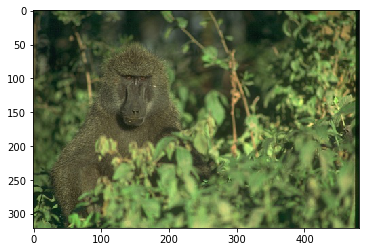

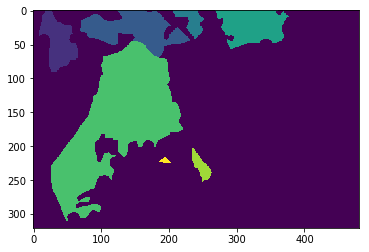

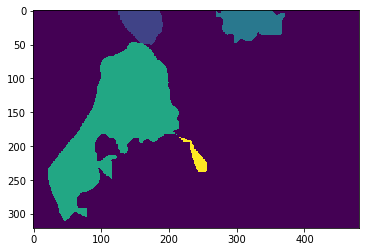

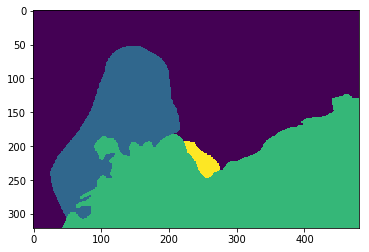

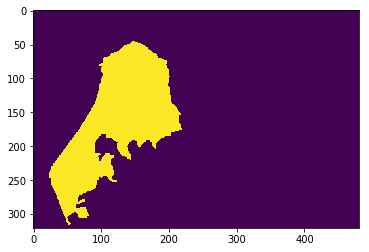

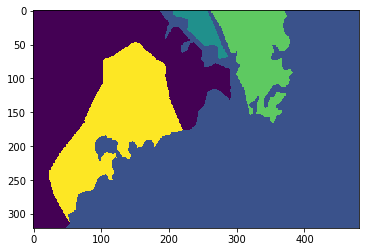

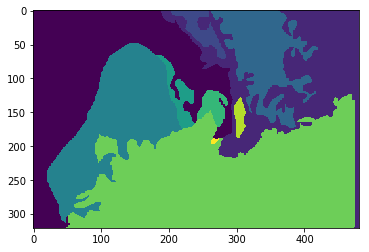

In [6]:
plt.imshow(train_imgs[1]);
plt.figure();
plt.imshow(train_gt[5]);
plt.figure();
plt.imshow(train_gt[6]);
plt.figure();
plt.imshow(train_gt[7]);
plt.figure();
plt.imshow(train_gt[8]);
plt.figure();
plt.imshow(train_gt[9]);
plt.figure();
plt.imshow(train_gt[10]);

In [7]:
num_pixels = 321 * 481
num_dimen = 3
num_imgs = len(train_imgs)
# num_val = len(val_imgs)
train_set = np.arange(num_pixels * num_dimen * num_imgs).reshape(num_pixels * num_imgs, num_dimen) 
# test_set = np.arange(num_pixels * num_dimen * num_imgs).reshape(num_pixels * num_imgs, num_dimen)
# val_set = np.arange(num_pixels * num_dimen * num_val).reshape(num_pixels * num_val, num_dimen) 
#transform the train and test image matrices to the correct shape.
for i in range(num_imgs):
    train_set[num_pixels*i:num_pixels+(num_pixels*i),:] = train_imgs[i].reshape(num_pixels,num_dimen)
#     test_set[num_pixels*i:num_pixels+(num_pixels*i),:] = test_imgs[i].reshape(num_pixels,num_dimen)

#transform the validation image matrixes to the correct shape. 
# for i in range(num_val):
#     val_set[num_pixels*i:num_pixels+(num_pixels*i), 0:num_dimen] = val_imgs[i].reshape(num_pixels,num_dimen)

In [24]:
from scipy.misc import imresize

def get_resized_train_set(train_imgs):
    resized_num_pixels=120*80
    num_dimen = 3
    num_imgs = len(train_imgs)
    resized_train_set = np.arange(resized_num_pixels * num_dimen * num_imgs).reshape(resized_num_pixels * num_imgs, num_dimen)
    
    for i in range(num_imgs):
        resized_train_set[resized_num_pixels*i:resized_num_pixels+(resized_num_pixels*i),:] = imresize(train_imgs[i],25).reshape(resized_num_pixels,num_dimen)
        
        
    return resized_train_set

In [82]:
def ClusteriseImage(clusters,data_mat,cluster_num):
    clusterised_mat= np.zeros(data_mat.shape,dtype=np.uint8)
    colors = []
    
    for i in range(cluster_num):
        colors.append(np.array([randint(0, 255),randint(0, 255),randint(0, 255)]))
    for i in range(data_mat.shape[0]):
        clusterised_mat[i] = colors[clusters[i]]
    return clusterised_mat
    

## Step 4 : Big Picture

Select the same five images used for Kmeans and display their corresponding ground truth against your segmentation results using Normalized-cut for the 5-NN graph, at K=5. Comment on the results.

In [8]:
import scipy.sparse as sp

In [62]:
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from scipy.sparse import lil_matrix

def computeAffinityAnnoy(data,num_neighbors):
    
    vector_length = data.shape[1]
    t = AnnoyIndex(vector_length)  # Length of item vector that will be indexed
    for i in range(0,num_pixels):
        t.add_item(i, data[i])

    t.build(1000) # 10 trees
    t.save('test.ann')

    # ...
    similarity_matrix=lil_matrix((num_pixels,num_pixels), dtype='float32')
    u = AnnoyIndex(vector_length)
    u.load('test.ann',prefault=True) # super fast, will just mmap the file

    for i in range(num_pixels):
        similarity_matrix[i,u.get_nns_by_item(i, num_neighbors,search_k=1000)]=1 # will find the 5nearest neighbors
    return similarity_matrix
    

def SpectralClustering(data, num_clusters=2, affinity='rbf', gamma=1.0, num_neighbors=1):
    if(affinity == 'rbf'):
        sim_matrix = rbf(data,data,gamma)
    elif(affinity == 'knn'):
        nearest_neigbhor = nn(n_neighbors=num_neighbors)
        nearest_neigbhor.fit(data)
        sim_matrix = nearest_neigbhor.kneighbors_graph(data, mode='connectivity').toarray()
    
    if(affinity =='annoy'):
        sim_matrix=computeAffinityAnnoy(data,num_neighbors)
        dense_deg_vector=np.asarray(sim_matrix.sum(axis=1)).reshape(-1)
        deg_matrix = sp.spdiags(np.reciprocal(dense_deg_vector), 0,dense_deg_vector.size,dense_deg_vector.size)
        laplace_matrix = deg_matrix - sim_matrix
        asym_laplace_matrix = deg_matrix.dot(laplace_matrix)
    else:
        deg_matrix = np.diag(np.sum(sim_matrix, axis=1))
        laplace_matrix = deg_matrix - sim_matrix
        asym_laplace_matrix = np.dot(np.linalg.inv(deg_matrix),laplace_matrix) 
    
    eig_values,eig_vectors = sp.linalg.eigs(asym_laplace_matrix)
    idx = np.real(eig_values).argsort()[:num_clusters]
    eig_vectors = np.real(eig_vectors[:,idx])
    rows_norm = np.linalg.norm(eig_vectors, axis=1)
    normalized_eig_vectors = (eig_vectors.T / rows_norm).T
    clusters = KMeans(n_clusters=num_clusters,n_jobs=-1).fit_predict(normalized_eig_vectors)
   
    return clusters


### Spectral clustering using Annoy library and sparse matrices on one image with full size of 481 * 321

In [63]:
clustersAnnoy = SpectralClustering(train_set,affinity='annoy',num_neighbors=5,num_clusters=5)

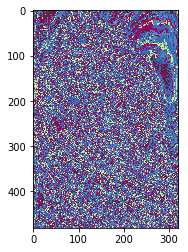

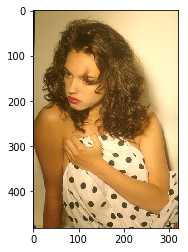

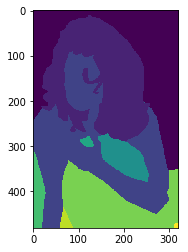

In [83]:
clusterised_mat=ClusteriseImage(clustersAnnoy,train_set[0:num_pixels],5)
plt.imshow(clusterised_mat.reshape(481,321,3))
plt.figure()
plt.imshow(train_imgs[0])
plt.figure()
plt.imshow(train_gt[0])

### Spectral clustering using resized images, 25 % of the original size of 481* 321

In [26]:
resized_train_set=get_resized_train_set(train_imgs)

/home/omar_swidan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [27]:
resized_num_pixels=120*80

#### Results using our own implementation of spectral clustering

In [54]:
clusters = SpectralClustering(resized_train_set[0:resized_num_pixels], num_clusters=5, affinity='knn', num_neighbors=5)

/home/omar_swidan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/home/omar_swidan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


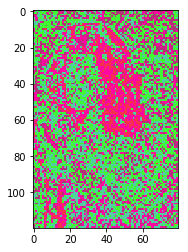

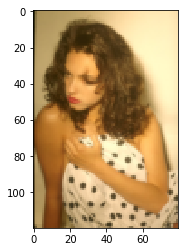

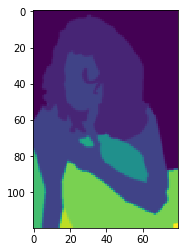

In [85]:
clusterised_mat=ClusteriseImage(clusters,resized_train_set[0:resized_num_pixels],5)
plt.imshow(clusterised_mat.reshape(120,80,3))
plt.figure()
plt.imshow(imresize(train_imgs[0],25))
plt.figure()
plt.imshow(imresize(train_gt[0],25))

#### Results using SKlearn's implementation of spectral clustering

In [43]:
from sklearn.cluster import SpectralClustering as SK_spectral_clustering

In [59]:
clustering=SK_spectral_clustering(n_clusters=5,affinity='nearest_neighbors',n_neighbors=5,n_jobs=-1).fit_predict(resized_train_set[0:resized_num_pixels])

/home/omar_swidan/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


/home/omar_swidan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/home/omar_swidan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


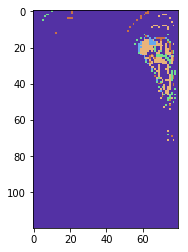

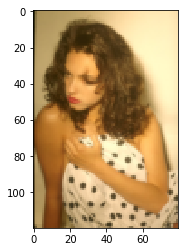

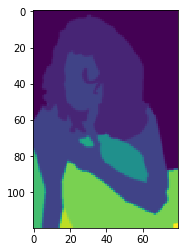

In [60]:
clusterised_mat=ClusteriseImage(clustering,resized_train_set[0:resized_num_pixels],5)
plt.imshow(clusterised_mat.reshape(120,80,3))
plt.figure()
plt.imshow(imresize(train_imgs[0],25))
plt.figure()
plt.imshow(imresize(train_gt[0],25))